# 1.Импорт модулей

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F  # Functional
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler

# # метрика качества 
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import pathlib as p

from sklearn.preprocessing import LabelEncoder

from collections import Counter

import gc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.Загрузка датасета

2 способо загрузки данных. Выбрать один из 2х

## Разархивировать с гугл диска

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/MIPT ФПМИ DS/3.ML/ДЗ/ДЗ_6/archive(4).zip'

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

## Загрузить с Каггла

In [ ]:
# !pip install kaggle # в колабе вроде не нужно

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset -p '/content/myds/'
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

100% 120M/121M [00:07<00:00, 24.3MB/s]
100% 121M/121M [00:07<00:00, 16.5MB/s]


In [ ]:
# !unzip face-expression-recognition-dataset.zip -d '/content/myds/'
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

# 3.Два класса по загрузке картинок: Свой и ImageFolder


При реализации своего класса столкнулся с постоянным дебаггинком ошибок при интеграции с pytorch Datloader. Плюс когда делал балансировку датасета с помощью WeightedRandomSampler у меня после загрузки в Dataloader, все значения labels были равны нулю. В итоге самописный класс будет без WeightedRandomSampler.

А в стандартном pytorch ImageFolder  смог реализовать связку с WeightedRandomSampler.

Определяю директории для треин и тест данных в папках

In [ ]:
train_dir = p.Path('/content/images/train')
test_dir = p.Path('/content/images/validation')

Посмотрю на одну картинку

In [ ]:
imgs = sorted(train_dir.rglob('*.jpg'))
imgs[0]

PosixPath('/content/images/train/angry/0.jpg')

Картинка черно-белая - значит 1 канал

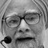

In [ ]:
image = Image.open(str(imgs[1]))
image.load()
image

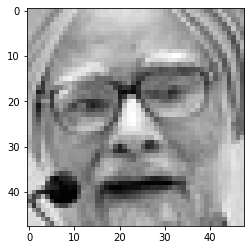

In [ ]:
plt.imshow(image,cmap = 'gray')

Common modes are “L” (luminance) for greyscale images

In [ ]:
print(image.format, image.size, image.mode)

JPEG (48, 48) L


## 3.1.MyDataset

Мой самописный класс

Класс по обработке картинок для подачи в Даталоадер

In [ ]:
class MyDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
      # images
        # пути переданных картинок
        self.images = sorted(images_filepaths.rglob('*.jpg'))
      # labels
        self.label_encoder = LabelEncoder()
      # название папки == класс в которой лежит картинка
        self.classes = [i.parent.name for i in self.images]
      # лейбелэнкодинг названий классов
        self.labels = self.label_encoder.fit_transform(self.classes)
      # трансформации картинок
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      # image
        image_filepath = self.images[idx]

      # с использованием cv2 возникают ошибки при аугментации, поэтому решил использовать PIL
        # image = cv2.imread(str(image_filepath)) # преобразование PurePath obj -> str иначе ошибка
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # PIL
        image = Image.open(str(image_filepath)).convert('RGB')
        image.load()

      # трансформации картинок
        if self.transform:
          image = self.transform(image)
          
      # label
        label = self.labels[idx]

        return image, label

Посмотрим на изображения без предобработки

In [ ]:
train_data_without_transformations = MyDataset(train_dir)

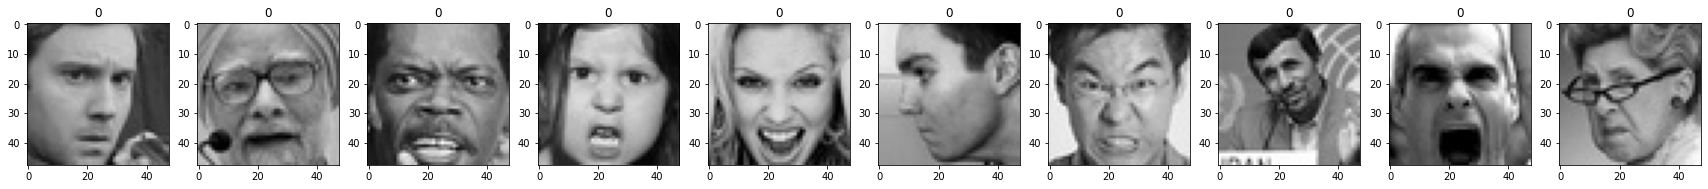

In [ ]:
def show_imgs(train_data):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(train_data[i][0], cmap='gray') 
        axes[i].set_title(train_data[i][1])
    plt.show()

show_imgs(train_data_without_transformations)

Теперь сделаем датасет с трансформациями

Поставим количество пикселей на вход в зависиммости от модели:

DenseNet121, VGG16  = 224;
VIT_b_14 = 518;
VIT_b_16 = 224;

In [ ]:
# тк у нас у картинки 48 пикселей по одной стороне, то нужно сделать ресайз до размеров на которых обучалась модель
input_size = 224

In [ ]:
# можно из коробки приводить все изображения к единому формату, конвертировать в торч тензор и нормализовывать
transform_train = transforms.Compose([
        # transforms.RandomResizedCrop(input_size),
        transforms.Resize(input_size), 
        transforms.AutoAugment(),
        transforms.ToTensor(), # тут так же rescale [0 to 1]  внутри этой операции
      # Для cv2 - по умолчанию 3 канала, но тк у нас серое изображение, то там будет R=G=B
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])
# отдельный для теста беза аугментации
transform_val = transforms.Compose([   
        transforms.Resize(input_size),                       
        transforms.ToTensor(), # тут так же rescale [0 to 1]  внутри этой операции
      # Для cv2 - по умолчанию 3 канала, но тк у нас серое изображение, то там будет R=G=B
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [ ]:
# инициализация треин и тест датасета
train_data = MyDataset(train_dir, transform=transform_train)
val_data = MyDataset(test_dir, transform=transform_val)

Посмотрим на элемент класса MyDataset

In [ ]:
# встроенный метод получает нужнуй элемент по индексу
img, lab = train_data.__getitem__(3993)

print(img.shape, lab)

torch.Size([3, 224, 224]) 1


In [ ]:
img, lab

(tensor([[[-1.5699, -1.5699, -1.5699,  ..., -1.7925, -1.7925, -1.7925],
          [-1.5699, -1.5699, -1.5699,  ..., -1.7925, -1.7925, -1.7925],
          [-1.5699, -1.5699, -1.5699,  ..., -1.7925, -1.7925, -1.7925],
          ...,
          [ 0.5878,  0.5878,  0.7419,  ...,  1.8550,  1.8550,  1.8550],
          [ 0.5878,  0.5878,  0.7419,  ...,  1.8550,  1.8550,  1.8550],
          [ 0.5878,  0.5878,  0.7419,  ...,  1.8550,  1.8550,  1.8550]],
 
         [[-1.4755, -1.4755, -1.4755,  ..., -1.7031, -1.7031, -1.7031],
          [-1.4755, -1.4755, -1.4755,  ..., -1.7031, -1.7031, -1.7031],
          [-1.4755, -1.4755, -1.4755,  ..., -1.7031, -1.7031, -1.7031],
          ...,
          [ 0.7304,  0.7304,  0.8880,  ...,  2.0259,  2.0259,  2.0259],
          [ 0.7304,  0.7304,  0.8880,  ...,  2.0259,  2.0259,  2.0259],
          [ 0.7304,  0.7304,  0.8880,  ...,  2.0259,  2.0259,  2.0259]],
 
         [[-1.2467, -1.2467, -1.2467,  ..., -1.4733, -1.4733, -1.4733],
          [-1.2467, -1.2467,

Посмотрим на получившиеся изображения с трансформациями

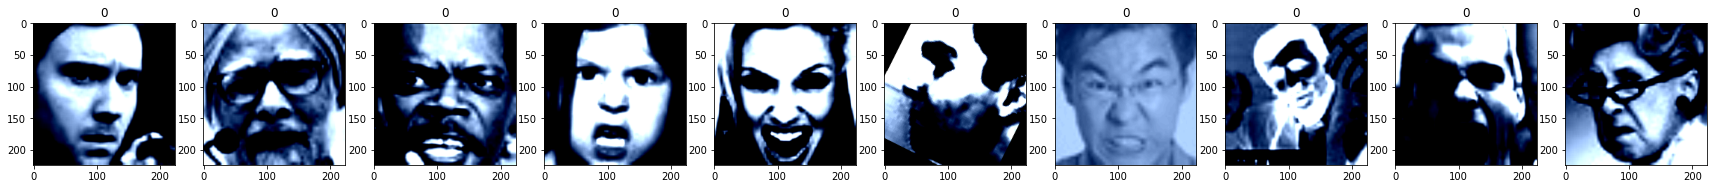

In [ ]:
def train_data_without_transformations(train_data):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        # загружаем изображения как тип ndarray (Height * Width * Channels)
        # будьте внимательны при преобразовании dtype в np.uint8 [целое число (от 0 до 255)].
        # в этом примере я не использую метод ToTensor() из torchvision.transforms
        # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
        axes[i].imshow(np.squeeze(np.transpose(train_data[i][0].numpy(), (1, 2, 0))), cmap='gray') # можно было без сквиза
        # axes[i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)), cmap='gray')
        axes[i].set_title(train_data[i][1])
    plt.show()

train_data_without_transformations(train_data)

Создам даталоадер и посмотрю на один батч

In [ ]:
# Dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True, pin_memory=True, num_workers=2)

Посмотрим на батч

In [ ]:
# батч картинок и батч ответов к картинкам
images, labels  = next(iter(train_loader))
print(images, labels)
print(images.shape,labels.shape)

tensor([[[[-1.1589, -1.1589, -1.1589,  ...,  1.5810,  1.7180,  1.7180],
          [-1.1589, -1.1589, -1.1589,  ...,  1.5810,  1.7180,  1.7180],
          [-1.1589, -1.1589, -1.1589,  ...,  1.5810,  1.7180,  1.7180],
          ...,
          [-0.8849, -0.8849, -0.8849,  ...,  1.0331,  1.0331,  1.0331],
          [-0.8849, -0.8849, -0.8849,  ...,  1.0331,  1.0331,  1.0331],
          [-0.8849, -0.8849, -0.8849,  ...,  1.0331,  1.0331,  1.0331]],

         [[-1.0553, -1.0553, -1.0553,  ...,  1.7458,  1.8859,  1.8859],
          [-1.0553, -1.0553, -1.0553,  ...,  1.7458,  1.8859,  1.8859],
          [-1.0553, -1.0553, -1.0553,  ...,  1.7458,  1.8859,  1.8859],
          ...,
          [-0.7752, -0.7752, -0.7752,  ...,  1.1856,  1.1856,  1.1856],
          [-0.7752, -0.7752, -0.7752,  ...,  1.1856,  1.1856,  1.1856],
          [-0.7752, -0.7752, -0.7752,  ...,  1.1856,  1.1856,  1.1856]],

         [[-0.8284, -0.8284, -0.8284,  ...,  1.9603,  2.0997,  2.0997],
          [-0.8284, -0.8284, -

### Балансировка датасета (не получилось)

Посчитаю количество элементов каждого класса

In [ ]:
classes, class_count = np.unique(train_data.labels,return_counts=True)
classes, class_count

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3993,  436, 4103, 7164, 4982, 4938, 3205]))

Распределю веса по классам

In [ ]:
sample_weighths = 1/class_count
sample_weighths

array([0.00025044, 0.00229358, 0.00024372, 0.00013959, 0.00020072,
       0.00020251, 0.00031201])

In [ ]:
class_weights = {classes[i] : 1 / class_count[i] for i in range(len(classes))}
class_weights

{0: 0.00025043826696719256,
 1: 0.0022935779816513763,
 2: 0.00024372410431391665,
 3: 0.00013958682300390843,
 4: 0.0002007226013649137,
 5: 0.0002025111381125962,
 6: 0.00031201248049921997}

Присвою веса классам

In [ ]:
sample_weights = [0] * len(train_data) # список из нулей длины len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_data)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

  0%|          | 0/28821 [00:00<?, ?it/s]

In [ ]:
sample_weights[25000:25010]

[0.0002025111381125962,
 0.0002025111381125962,
 0.0002025111381125962,
 0.0002025111381125962,
 0.0002025111381125962,
 0.0002025111381125962,
 0.0002025111381125962,
 0.0002025111381125962,
 0.0002025111381125962,
 0.0002025111381125962]

Создам WeightedRandomSampler

In [ ]:
train_sampler = WeightedRandomSampler(sample_weights, num_samples = train_data.__len__(), replacement=True)

Создам даталоадер + WeightedRandomSampler

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1000, shuffle = False, pin_memory=True, num_workers=2, sampler = train_sampler)

Посмотрим на батч

In [ ]:
# батч картинок и батч ответов к картинкам
images, labels  = next(iter(train_loader))
print(images, labels)
print(images.shape,labels.shape)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [ ]:
classes, class_count = np.unique(labels.numpy(),return_counts=True)
classes, class_count

(array([0, 1, 2, 3, 4, 5, 6]), array([150, 122, 146, 127, 152, 156, 147]))

In [ ]:
d={}
for x_batch, y_batch in tqdm(train_loader):
  classes, class_count = np.unique(y_batch.numpy(),return_counts=True)
  for i in range(len(classes)):
    if classes[i] not in d:
      d[classes[i]]= class_count[i]
    else:
      d[classes[i]]+=class_count[i]
d

  0%|          | 0/29 [00:00<?, ?it/s]

{0: 4115, 1: 4173, 2: 4055, 3: 4196, 4: 4110, 5: 4134, 6: 4038}

Видно, что в при использовании сэмлера даталоадер примерно равномерно выдает нам картинки разных классов, значит с дисбалансом справились

Отобразим картинки

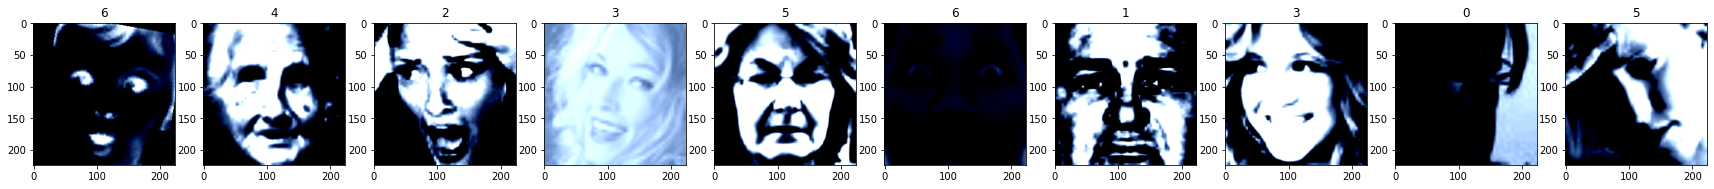

In [ ]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        # загружаем изображения как тип ndarray (Height * Width * Channels)
        # будьте внимательны при преобразовании dtype в np.uint8 [целое число (от 0 до 255)].
        # в этом примере я не использую метод ToTensor() из torchvision.transforms
        # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray') # можно было без сквиза
        # axes[i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

## 3.2.ImageFolder

Тоже самое что и выше, только использую стандартный класс пайторча ImageFolder для создания датасета

Посмотрим на изображения без предобработки

In [ ]:
train_data_without_transformations = datasets.ImageFolder(train_dir)

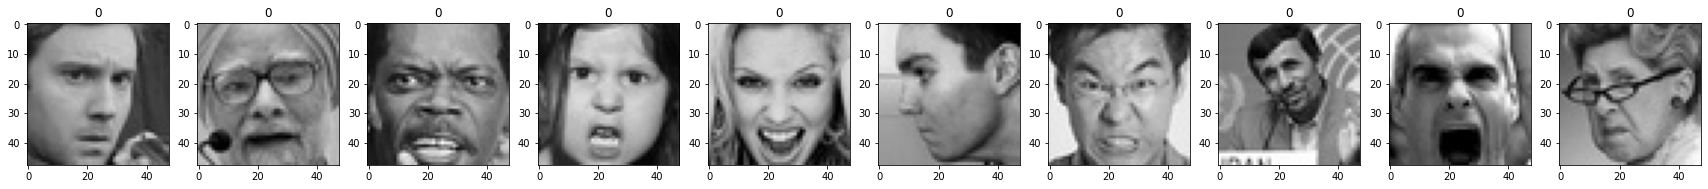

In [ ]:
def show_imgs(train_data):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(train_data[i][0], cmap='gray') 
        axes[i].set_title(train_data[i][1])
    plt.show()

show_imgs(train_data_without_transformations)

Теперь сделаем датасет с трансформациями

Поставим количество пикселей на вход в зависиммости от модели:

DenseNet121, VGG16  = 224;
VIT_b_14 = 518;
VIT_b_16 = 224;

In [ ]:
# тк у нас у картинки 48 пикселей по одной стороне, то нужно сделать ресайз до размеров на которых обучалась модель
input_size = 224

In [ ]:
# можно из коробки приводить все изображения к единому формату, конвертировать в торч тензор и нормализовывать
transform_train = transforms.Compose([
        # transforms.RandomResizedCrop(input_size),
        transforms.Resize(input_size), 
        transforms.AutoAugment(),
        transforms.ToTensor(), # тут так же rescale [0 to 1]  внутри этой операции
      # Для cv2 - по умолчанию 3 канала, но тк у нас серое изображение, то там будет R=G=B
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])
# отдельный для теста беза аугментации
transform_val = transforms.Compose([   
        transforms.Resize(input_size),                       
        transforms.ToTensor(), # тут так же rescale [0 to 1]  внутри этой операции
      # Для cv2 - по умолчанию 3 канала, но тк у нас серое изображение, то там будет R=G=B
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [ ]:
# инициализация треин и тест датасета
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data = datasets.ImageFolder(test_dir, transform=transform_val)

In [ ]:
# встроенный метод получает нужнуй элемент по индексу
img, lab = train_data.__getitem__(3993)

print(img.shape, lab)

torch.Size([3, 224, 224]) 1


In [ ]:
img, lab

(tensor([[[ 0.0741,  0.0741,  0.0741,  ..., -0.0629, -0.0629, -0.0629],
          [ 0.0741,  0.0741,  0.0741,  ..., -0.0629, -0.0629, -0.0629],
          [ 0.0741,  0.0741,  0.0741,  ..., -0.0629, -0.0629, -0.0629],
          ...,
          [ 0.0398,  0.0398,  0.0398,  ...,  0.2624,  0.2624,  0.2624],
          [ 0.0398,  0.0398,  0.0398,  ...,  0.2624,  0.2624,  0.2624],
          [ 0.0398,  0.0398,  0.0398,  ...,  0.2624,  0.2624,  0.2624]],
 
         [[ 0.2052,  0.2052,  0.2052,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.2052,  0.2052,  0.2052,  ...,  0.0651,  0.0651,  0.0651],
          ...,
          [ 0.1702,  0.1702,  0.1702,  ...,  0.3978,  0.3978,  0.3978],
          [ 0.1702,  0.1702,  0.1702,  ...,  0.3978,  0.3978,  0.3978],
          [ 0.1702,  0.1702,  0.1702,  ...,  0.3978,  0.3978,  0.3978]],
 
         [[ 0.4265,  0.4265,  0.4265,  ...,  0.2871,  0.2871,  0.2871],
          [ 0.4265,  0.4265,

Посмотрим на получившиеся изображения с трансформациями

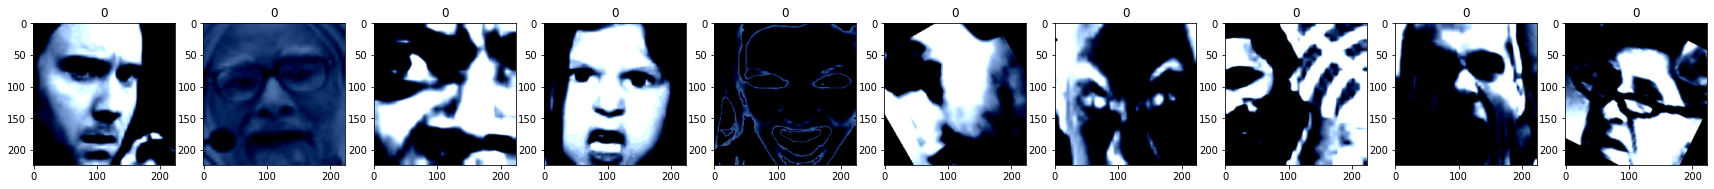

In [ ]:
def train_data_without_transformations(train_data):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        # загружаем изображения как тип ndarray (Height * Width * Channels)
        # будьте внимательны при преобразовании dtype в np.uint8 [целое число (от 0 до 255)].
        # в этом примере я не использую метод ToTensor() из torchvision.transforms
        # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
        axes[i].imshow(np.squeeze(np.transpose(train_data[i][0].numpy(), (1, 2, 0))), cmap='gray') # можно было без сквиза
        # axes[i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)), cmap='gray')
        axes[i].set_title(train_data[i][1])
    plt.show()

train_data_without_transformations(train_data)

### Балансировка датасета

In [ ]:
# классы и количество элементов каждого класса
classes, class_count = np.unique(train_data.targets,return_counts=True)
classes, class_count

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3993,  436, 4103, 7164, 4982, 4938, 3205]))

Видно что количество экземпляров 1го класса значительно ниже. Поэтому сделаем балансировку при сэмплинге

In [ ]:
# веса для каждого класса
sample_weighths = 1/class_count
sample_weighths

array([0.00025044, 0.00229358, 0.00024372, 0.00013959, 0.00020072,
       0.00020251, 0.00031201])

In [ ]:
# поставим в соответствие класс : вес
class_weights = {classes[i] : 1 / class_count[i] for i in range(len(classes))}
class_weights

{0: 0.00025043826696719256,
 1: 0.0022935779816513763,
 2: 0.00024372410431391665,
 3: 0.00013958682300390843,
 4: 0.0002007226013649137,
 5: 0.0002025111381125962,
 6: 0.00031201248049921997}

In [ ]:
# теперь каждому элементу из каждого класса назначим соответсвующий вес
sample_weights = [0] * len(train_data) # список из нулей длины датасета
for i, (data, label) in enumerate(tqdm(train_data)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

  0%|          | 0/28821 [00:00<?, ?it/s]

In [ ]:
len(sample_weights)

28821

In [ ]:
# посмотрим на веса
sample_weights[28800:]

[0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997,
 0.00031201248049921997]

In [ ]:
# WeightedRandomSampler для Dataloader, который будет брать элементы в соответствии их весов
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_data), replacement=True)

In [ ]:
# Dataloader c WeightedRandomSampler
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = False, pin_memory=True, num_workers=2, sampler = train_sampler)

Посмотрим на батч

In [ ]:
# батч картинок и батч ответов к картинкам
images, labels  = next(iter(train_loader))
print(images, labels)
print(images.shape,labels.shape)

tensor([[[[-0.1828, -0.1828, -0.1828,  ...,  1.4612,  1.4612,  1.4612],
          [-0.1828, -0.1828, -0.1828,  ...,  1.4612,  1.4612,  1.4612],
          [-0.1828, -0.1828, -0.1828,  ...,  1.4612,  1.4612,  1.4612],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -0.4568, -0.4568, -0.4568],
          [-2.1179, -2.1179, -2.1179,  ..., -0.4568, -0.4568, -0.4568],
          [-2.1179, -2.1179, -2.1179,  ..., -0.4568, -0.4568, -0.4568]],

         [[-0.0574, -0.0574, -0.0574,  ...,  1.6232,  1.6232,  1.6232],
          [-0.0574, -0.0574, -0.0574,  ...,  1.6232,  1.6232,  1.6232],
          [-0.0574, -0.0574, -0.0574,  ...,  1.6232,  1.6232,  1.6232],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -0.3375, -0.3375, -0.3375],
          [-2.0357, -2.0357, -2.0357,  ..., -0.3375, -0.3375, -0.3375],
          [-2.0357, -2.0357, -2.0357,  ..., -0.3375, -0.3375, -0.3375]],

         [[ 0.1651,  0.1651,  0.1651,  ...,  1.8383,  1.8383,  1.8383],
          [ 0.1651,  0.1651,  

In [ ]:
# посмотрим как даталоаэдер с помощью сэмплера будет сэмплировать классы
d={}
for x_batch, y_batch in tqdm(train_loader):
  classes, class_count = np.unique(y_batch.numpy(),return_counts=True)
  for i in range(len(classes)):
    if classes[i] not in d:
      d[classes[i]]= class_count[i]
    else:
      d[classes[i]]+=class_count[i]
d

  0%|          | 0/901 [00:00<?, ?it/s]

{0: 4096, 1: 4128, 2: 4102, 3: 4231, 4: 4093, 5: 4105, 6: 4066}

Видно что количество элементов каждого класса примерно одинаковое. Таким образом отбалансировали датасет

# 4.Вспомогательные функции для обучения

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
  
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    # val_acc = running_corrects.cpu().numpy() / processed_size # в следующий раз сделать так  чтобы не сохранялся тензор

    return val_loss, val_acc

In [ ]:
def modelsaver(epoch, model, optimizer, scheduler, history, path_to_save):
  if scheduler:
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler' : scheduler.state_dict(),
                'history': history,
                }, 
              path_to_save)
  else:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler' : scheduler,
                'history': history,
                }, 
              path_to_save)

In [ ]:
def train(train_data, val_data, model, optimizer, criterion, epochs, batch_size, path_to_save, sampler = None, scheduler = None):
    
  #train loader
    if sampler:
      train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, pin_memory=True, num_workers=2)
    else:
      train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True, pin_memory=True, num_workers=2)

  # val loader
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True, pin_memory=True, num_workers=2)

    history = []

    # lowest_loss = float('inf')
    highest_acc = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
          #train
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print(f'train_loss = {train_loss}, train_acc = {train_acc}')

          #test
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print(f'val_loss = {val_loss}, val_acc = {val_acc}')

          # save losses and accuracies
            history.append((train_loss, train_acc, val_loss, val_acc))
            
          #сохраню модель
            if val_acc > highest_acc:
              modelsaver(epoch, model, optimizer, scheduler, history, path_to_save)
              highest_acc = val_acc
              print(f'new model was saved with val_acc = highest_acc = {highest_acc}')

          #lr scheduler
            if scheduler:
              scheduler.step()

          # вывести результаты эпохи
            print(f'epoch = {epoch}, train_loss = {train_loss}, train_acc = {train_acc}, val_loss = {val_loss}, val_acc = {val_acc}')

          # обновить бар
            pbar_outer.update(1)

    return history

In [ ]:
def test(val_data, model, criterion, batch_size):
  #val loader
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True, pin_memory=True, num_workers=2)

  #test
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    print(f'val_loss = {val_loss}, val_acc = {val_acc}')

In [ ]:
def plot_history(history):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  fig, ax = plt.subplots(1,2,figsize=(15, 7))
  fig.suptitle('Validation loss and accuracy')

  for h in history:
    train_loss.append(h[0])
    train_acc.append(h[1])
    val_loss.append(h[2])
    val_acc.append(h[3].cpu().numpy()) # тк торч тензор оказался

  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label = 'train_loss')
  ax[0].plot(val_loss, label = 'val_loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].plot(train_acc, label = 'train_acc')
  ax[1].plot(val_acc, label = 'val_acc')
  ax[1].legend()

<font size = '5'> Далее попробовал обучать модели Densenet, VGG, VIT. На первых 2х accuracy получался в районе до 0,4. Взял Vit и  acc получился 0,52 примерно. Так же пробовал обучать модели и со  сбалансированными сэмплингом WeightedRandomSampler и без него. Результаты примерно одинаковы были, но я заметил что без него немного лучше.</font>

# 4.Подготовка модели Densenet121

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели densenet121 претренированной
model = models.densenet121(weights = 'IMAGENET1K_V1')

In [ ]:
# параметры модели
model.parameters

<bound method Module.parameters of DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
# убираем обновление градиентов
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.classes)
num_classes

7

In [ ]:
# последний слой - классификатор
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier.in_features
num_ftrs

1024

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier = nn.Linear(num_ftrs, num_classes)

In [ ]:
# получившийся классификатор
model.classifier

Linear(in_features=1024, out_features=7, bias=True)

Feature extraction

параметры модели которые будут оптимизироваться  - > новый последний слой. Так как это feature extraction, то надо обучать только новый добавленный слой. В fine tuning надо было бы обучать модель полностью ( новый слой и старые)

 PS : в финальной реализации я применял model.parameters() в optimizer тк у меня результаты получались хуже если ставить params_to_update. Надо бы разобраться еще, тк это было в офиц статье по торчу.

In [ ]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)
        print(param)

classifier.weight
Parameter containing:
tensor([[ 0.0140,  0.0288, -0.0126,  ..., -0.0310, -0.0093,  0.0223],
        [-0.0087,  0.0172,  0.0098,  ...,  0.0233,  0.0054, -0.0158],
        [ 0.0127,  0.0062, -0.0071,  ..., -0.0125,  0.0288,  0.0016],
        ...,
        [ 0.0167, -0.0017,  0.0257,  ..., -0.0130,  0.0292,  0.0291],
        [-0.0038, -0.0209, -0.0234,  ..., -0.0255,  0.0048, -0.0237],
        [-0.0236, -0.0202,  0.0190,  ..., -0.0008, -0.0277, -0.0310]],
       requires_grad=True)
classifier.bias
Parameter containing:
tensor([ 0.0263,  0.0006,  0.0121, -0.0167, -0.0233, -0.0009, -0.0053],
       requires_grad=True)


Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

6078

In [ ]:
# имя для сохраненяемой модели
model_name = 'best_model_6'

# куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/MIPT ФПМИ DS/3.ML/ДЗ/ДЗ_6/' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# optimizer = torch.optim.Adam(params_to_update, amsgrad = True, weight_decay = 1e-3, lr = 1e-3)
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# # scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# размер батча
batch_size = 1024

# количество эпох
epochs = 10

# обучение
history = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save = PATH, sampler = None, scheduler = None)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

train_loss = 1.7569317573817904, train_acc = 0.2835085527913674


  0%|          | 0/14 [00:00<?, ?it/s]

val_loss = 1.6300264971808944, val_acc = 0.3705066515709029
new model was saved with val_acc = highest_acc = 0.3705066515709029
epoch = 0, train_loss = 1.7569317573817904, train_acc = 0.2835085527913674, val_loss = 1.6300264971808944, val_acc = 0.3705066515709029


  0%|          | 0/57 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

В попытках обучить эту модель максимальный скор был примерно 0,4

# 5.Подготовка модели VGG16

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели densenet121 претренированной
model = models.vgg16_bn(weights = 'IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [ ]:
# убираем обновление градиентов
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.classes)
num_classes

7

In [ ]:
# последние слои - классификатор
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=7, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=7, bias=True)
)

Feature extraction

параметры модели которые будут оптимизироваться  - > новый последний слой. Так как это feature extraction, то надо обучать только новый добавленный слой. В fine tuning надо было бы обучать модель полностью ( новый слой и старые)

 PS : в финальной реализации я применял model.parameters() в optimizer тк у меня результаты получались хуже если ставить params_to_update. Надо бы разобраться еще, тк это было в офиц статье по торчу.

In [ ]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)
        print(param)

classifier.weight
Parameter containing:
tensor([[ 0.0140,  0.0288, -0.0126,  ..., -0.0310, -0.0093,  0.0223],
        [-0.0087,  0.0172,  0.0098,  ...,  0.0233,  0.0054, -0.0158],
        [ 0.0127,  0.0062, -0.0071,  ..., -0.0125,  0.0288,  0.0016],
        ...,
        [ 0.0167, -0.0017,  0.0257,  ..., -0.0130,  0.0292,  0.0291],
        [-0.0038, -0.0209, -0.0234,  ..., -0.0255,  0.0048, -0.0237],
        [-0.0236, -0.0202,  0.0190,  ..., -0.0008, -0.0277, -0.0310]],
       requires_grad=True)
classifier.bias
Parameter containing:
tensor([ 0.0263,  0.0006,  0.0121, -0.0167, -0.0233, -0.0009, -0.0053],
       requires_grad=True)


Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

320

In [ ]:
# имя для сохраненяемой модели
model_name = 'best_model_VGG16_bn_1'

# куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/MIPT ФПМИ DS/3.ML/ДЗ/ДЗ_6/' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# optimizer = torch.optim.Adam(params_to_update, amsgrad = True, weight_decay = 1e-3, lr = 1e-3)
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# # scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# размер батча
batch_size = 128

# количество эпох
epochs = 10

# обучение
history = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save = PATH, sampler = None, scheduler = None)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.7381860136237128, train_acc = 0.3005447416814129


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.5585985504261604, val_acc = 0.39951882253042736
new model was saved with val_acc = highest_acc = 0.39951882253042736
epoch = 0, train_loss = 1.7381860136237128, train_acc = 0.3005447416814129, val_loss = 1.5585985504261604, val_acc = 0.39951882253042736


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.7042352871305677, train_acc = 0.32403455813469345


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.545169101063739, val_acc = 0.41126521369940555
new model was saved with val_acc = highest_acc = 0.41126521369940555
epoch = 1, train_loss = 1.7042352871305677, train_acc = 0.32403455813469345, val_loss = 1.545169101063739, val_acc = 0.41126521369940555


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.6985744848360869, train_acc = 0.3282328857430346


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.5288500250684887, val_acc = 0.413812623832437
new model was saved with val_acc = highest_acc = 0.413812623832437
epoch = 2, train_loss = 1.6985744848360869, train_acc = 0.3282328857430346, val_loss = 1.5288500250684887, val_acc = 0.413812623832437


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.6967593838970756, train_acc = 0.33236181950660976


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.551651199579981, val_acc = 0.3872063402207755
epoch = 3, train_loss = 1.6967593838970756, train_acc = 0.33236181950660976, val_loss = 1.551651199579981, val_acc = 0.3872063402207755


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.710123744097289, train_acc = 0.32847576419971547


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.5394101466465833, val_acc = 0.40135861873761675
epoch = 4, train_loss = 1.710123744097289, train_acc = 0.32847576419971547, val_loss = 1.5394101466465833, val_acc = 0.40135861873761675


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.7075361342901807, train_acc = 0.3290656118802262


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.5205344785012236, val_acc = 0.4165015567506368
new model was saved with val_acc = highest_acc = 0.4165015567506368
epoch = 5, train_loss = 1.7075361342901807, train_acc = 0.3290656118802262, val_loss = 1.5205344785012236, val_acc = 0.4165015567506368


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.703865192491653, train_acc = 0.3281634918982686


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.509802631065861, val_acc = 0.4279649023492782
new model was saved with val_acc = highest_acc = 0.4279649023492782
epoch = 6, train_loss = 1.703865192491653, train_acc = 0.3281634918982686, val_loss = 1.509802631065861, val_acc = 0.4279649023492782


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.7025450335663737, train_acc = 0.3345477256167378


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.5200030770613593, val_acc = 0.4197565808095103
epoch = 7, train_loss = 1.7025450335663737, train_acc = 0.3345477256167378, val_loss = 1.5200030770613593, val_acc = 0.4197565808095103


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.7098412045929203, train_acc = 0.3267756150029492


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.525734324209622, val_acc = 0.41310500990659493
epoch = 8, train_loss = 1.7098412045929203, train_acc = 0.3267756150029492, val_loss = 1.525734324209622, val_acc = 0.41310500990659493


  0%|          | 0/226 [00:00<?, ?it/s]

train_loss = 1.7062235453967551, train_acc = 0.32986364109503485


  0%|          | 0/56 [00:00<?, ?it/s]

val_loss = 1.5111894368652983, val_acc = 0.4240022643645627
epoch = 9, train_loss = 1.7062235453967551, train_acc = 0.32986364109503485, val_loss = 1.5111894368652983, val_acc = 0.4240022643645627


Как видно val_acc улучшился примерно до 0,42. Уже лучше, но попробую другую модель

# 5.Подготовка модели VIT

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# инициализация модели densenet121 претренированной
model = models.vit_b_16(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
model.parameters

<bound method Module.parameters of VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, eleme

In [ ]:
# убираем обновление градиентов
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# количество классов в датасете
num_classes = len(train_data.classes)
num_classes

7

In [ ]:
# последние слои - классификатор
model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.heads.head.in_features
num_ftrs

768

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.heads.head = nn.Linear(num_ftrs, num_classes)

In [ ]:
model.heads

Sequential(
  (head): Linear(in_features=768, out_features=7, bias=True)
)

Feature extraction

параметры модели которые будут оптимизироваться  - > новый последний слой. Так как это feature extraction, то надо обучать только новый добавленный слой. В fine tuning надо было бы обучать модель полностью ( новый слой и старые)

 PS : в финальной реализации я применял model.parameters() в optimizer тк у меня результаты получались хуже если ставить params_to_update. Надо бы разобраться еще, тк это было в офиц статье по торчу.

In [ ]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)
        print(param)

classifier.weight
Parameter containing:
tensor([[ 0.0140,  0.0288, -0.0126,  ..., -0.0310, -0.0093,  0.0223],
        [-0.0087,  0.0172,  0.0098,  ...,  0.0233,  0.0054, -0.0158],
        [ 0.0127,  0.0062, -0.0071,  ..., -0.0125,  0.0288,  0.0016],
        ...,
        [ 0.0167, -0.0017,  0.0257,  ..., -0.0130,  0.0292,  0.0291],
        [-0.0038, -0.0209, -0.0234,  ..., -0.0255,  0.0048, -0.0237],
        [-0.0236, -0.0202,  0.0190,  ..., -0.0008, -0.0277, -0.0310]],
       requires_grad=True)
classifier.bias
Parameter containing:
tensor([ 0.0263,  0.0006,  0.0121, -0.0167, -0.0233, -0.0009, -0.0053],
       requires_grad=True)


Видно что обучаемые параметры это вес и смещение последнего линейного слоя

In [ ]:
# перенос финальной модели на устройство
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# тест форварда модели
# x = torch.rand(4, 3, 224, 224)
# out = model.forward(x)

## Обучение

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Dec 28 20:03:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |  12566MiB / 15109MiB |     50%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# имя для сохраненяемой модели
model_name = 'best_model_vit_b_16_1'

# куда сохраняем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/MIPT ФПМИ DS/3.ML/ДЗ/ДЗ_6/' + model_name + '.pt'

# лосс
criterion = nn.CrossEntropyLoss()

# optimizer
# optimizer = torch.optim.Adam(params_to_update, amsgrad = True, weight_decay = 1e-3, lr = 1e-3)
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, weight_decay = 1e-5, lr = 1e-3)

# # scheduler
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# размер батча
batch_size = 250

# количество эпох
epochs = 10

# обучение
history = train(train_data, val_data, model=model, optimizer = optimizer,
                criterion = criterion, epochs=epochs, batch_size=batch_size, 
                path_to_save = PATH, sampler = None, scheduler = None)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.5585781876265987, train_acc = 0.39963915200721695


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.3977393970386927, val_acc = 0.4823096518539485
new model was saved with val_acc = highest_acc = 0.4823096518539485
epoch = 0, train_loss = 1.5585781876265987, train_acc = 0.39963915200721695, val_loss = 1.3977393970386927, val_acc = 0.4823096518539485


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.4218635530376835, train_acc = 0.4620589153742063


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.343259133902549, val_acc = 0.49108406453439
new model was saved with val_acc = highest_acc = 0.49108406453439
epoch = 1, train_loss = 1.4218635530376835, train_acc = 0.4620589153742063, val_loss = 1.343259133902549, val_acc = 0.49108406453439


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.3777557553682804, train_acc = 0.4789563165747198


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.3031456579137652, val_acc = 0.5162751202943674
new model was saved with val_acc = highest_acc = 0.5162751202943674
epoch = 2, train_loss = 1.3777557553682804, train_acc = 0.4789563165747198, val_loss = 1.3031456579137652, val_acc = 0.5162751202943674


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.3505064926133894, train_acc = 0.4911349363311474


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.276580556877065, val_acc = 0.5225021228417774
new model was saved with val_acc = highest_acc = 0.5225021228417774
epoch = 3, train_loss = 1.3505064926133894, train_acc = 0.4911349363311474, val_loss = 1.276580556877065, val_acc = 0.5225021228417774


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.332020112416832, train_acc = 0.4968252316019569


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.2643725952344949, val_acc = 0.525757146900651
new model was saved with val_acc = highest_acc = 0.525757146900651
epoch = 4, train_loss = 1.332020112416832, train_acc = 0.4968252316019569, val_loss = 1.2643725952344949, val_acc = 0.525757146900651


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.3122161226473437, train_acc = 0.5050137052843413


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.2542089130059875, val_acc = 0.5268893291819983
new model was saved with val_acc = highest_acc = 0.5268893291819983
epoch = 5, train_loss = 1.3122161226473437, train_acc = 0.5050137052843413, val_loss = 1.2542089130059875, val_acc = 0.5268893291819983


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.3044166084025959, train_acc = 0.5083446098331078


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.2476932890112191, val_acc = 0.530568921596377
new model was saved with val_acc = highest_acc = 0.530568921596377
epoch = 6, train_loss = 1.3044166084025959, train_acc = 0.5083446098331078, val_loss = 1.2476932890112191, val_acc = 0.530568921596377


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.296167673001965, train_acc = 0.5094896082717463


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.2396425154875197, val_acc = 0.5393433342768186
new model was saved with val_acc = highest_acc = 0.5393433342768186
epoch = 7, train_loss = 1.296167673001965, train_acc = 0.5094896082717463, val_loss = 1.2396425154875197, val_acc = 0.5393433342768186


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.2839645463328941, train_acc = 0.514694146629194


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.2297763156715413, val_acc = 0.5430229266911972
new model was saved with val_acc = highest_acc = 0.5430229266911972
epoch = 8, train_loss = 1.2839645463328941, train_acc = 0.514694146629194, val_loss = 1.2297763156715413, val_acc = 0.5430229266911972


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss = 1.2808102918016162, train_acc = 0.5164983865931092


  0%|          | 0/29 [00:00<?, ?it/s]

val_loss = 1.230451911426353, val_acc = 0.5417492216246815
epoch = 9, train_loss = 1.2808102918016162, train_acc = 0.5164983865931092, val_loss = 1.230451911426353, val_acc = 0.5417492216246815


Как  видно val_acc вырос до 0.54 примерно .  На этом перебор моделей закончу, тк target acc по этому датасету 0,5-0,6

# 6.Прогон готовой модели с загрузкой

## загрузка и подготовка модели

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# имя для загружаемой модели
model_name = 'best_model_vit_b_16_1'

# откуда загружаем модель
PATH = '/content/drive/MyDrive/Colab Notebooks/MIPT ФПМИ DS/3.ML/ДЗ/ДЗ_6/' + model_name + '.pt'

# инициализируем модель
model = models.vit_b_16()

In [ ]:
model.parameters

<bound method Module.parameters of VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, eleme

In [ ]:
# количество классов в датасете
num_classes = len(np.unique(val_data.classes)) # через unique тк в классе считаются по сути все файлы
num_classes

7

In [ ]:
# последние слои - классификатор
model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
# количество признаков на вход новому последнему линейному слою
num_ftrs = model.heads.head.in_features
num_ftrs

768

In [ ]:
# заменяем последний слой новым линейным с нужным количеством выходных классов
model.heads.head = nn.Linear(num_ftrs, num_classes)

In [ ]:
model.heads

Sequential(
  (head): Linear(in_features=768, out_features=7, bias=True)
)

In [ ]:
# загружаем из чекпоинты модели по пути
checkpoint = torch.load(PATH, map_location = device)

# присваиваем веса от обученной модели
# помимо этого можно вытащить и другие параметры, см ф-ю model_saver
model.load_state_dict(checkpoint['model_state_dict'])

# лосс
criterion = nn.CrossEntropyLoss()

# размер батча
batch_size = 250

model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Прогон загруженной лучшей модели на тесте

In [ ]:
# почистим кеш
torch.cuda.empty_cache()
gc.collect()

314

Резултаты val_accuracy and val_loss на тестовой выборке

In [ ]:
test(val_data, model, criterion, batch_size)

## Графики

Тут просто загружу и визулизирую из сохраненной модели историю лоссов и accuracy на train, test

In [ ]:
test_history = checkpoint['history']

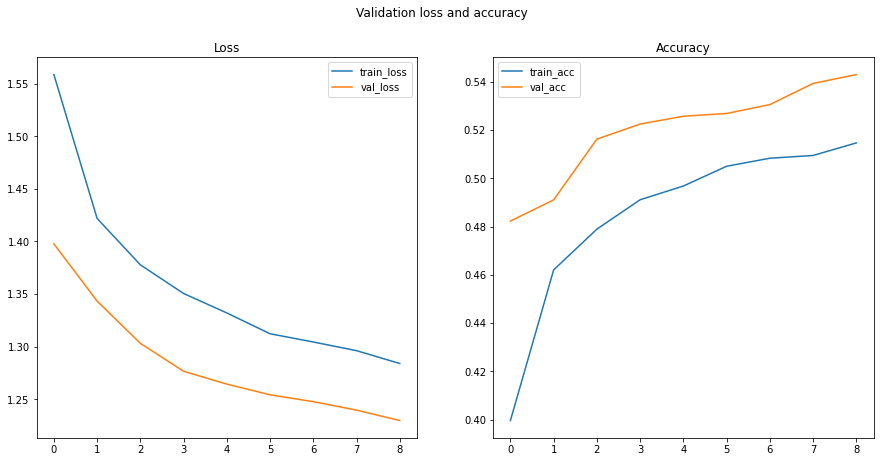

In [ ]:
plot_history(test_history)

# Вывод

<font size = '4'>
В этой работе я сделал собственный загрузчик данных и устранил дисбаланс в классах с помощью WeightedRandomSampler. Было дообучено 3 модели (Densenet, VGG, VIT) в попытках улучшить validation accuracy. Модели дообучались как со сбалансированным распределением по классам так и без. Заметил, что без WeightedRandomSampler качество немного лучше. В итоге после всех попыток обучений у  последней модели получилось качество лучше всего, примерно 0,52. Лучшая модель сохранялась в гугл диск во время обучения. При не обходимости можно загрузить сохраненную модель и посмотреть метрики которые логировались во время обучения.
</font>